### 1 Data set


In this homework we want to classify bacteria based on their genome sequences. The 'genomics_ood' data set is already inbuilt in Tensorflow. The input will be a genomic sequence, which (short biology recap) consists of the characters $\{\mathrm{A}, \mathrm{C}, \mathrm{G}, \mathrm{T}\}$ (also known as nucleotides). Each genomic sequence will be 250 characters long, with each char one of the 4 options. We want to classify each genome sequence to 1 of 10 bacteria populations. (Technically, the data set also contains 120 more 'out of distribution' classes which are stored in test_ood and validation_ood, but you can disregard them for this homework.) Learn more about the data set here and have a look at example elements: https: //wWW.tensorflow.org/datasets/catalog/genomics_ood

First you will need to load the data set from the module tensorflow_datasets. 1

We have heard of some troubles with this data set and Windows. In case you encounter error messages when loading the data set when running it on your own machine, please consider switching to Colab. (Or trying a dual boot Ubuntu option. If none of that is an option for you, we recommend you working together with group mates who can load the data set.)

Then we will need some preparations on the data:

Take out a bunch of examples for our network. The whole dataset contains 1 million training examples and $100.000$ test examples. It will be sufficient to use $100.000$ examples for training and 1000 for testing. (If you are not sure what is the purpose of having a training and testing data set, check the chapter 'Data and Data Pipelines' on Courseware Week 03 again. But we will also talk about that next week in more detail.)

The genomic sequences come as string-tensor which are not so handy to work with. Instead, we would like to have the genomic sequence with one-hot-vectors for encoding the nucleotides $(\mathrm{A}, \mathrm{C}, \mathrm{G}, \mathrm{T})$. But because the sequences are string tensors, we cannot simply call tf. one_hot $(x, 4)$ on them. Therefore we need a function which converts the string tensor into a usable tensor that contains the one-hot-encoded sequence. You can try to build this function yourself (which might potentially be tricky, but we will give you some instructions in the hints $^{2}$ ). Otherwise we also provide it for you in the end of the document. Also apply one-hot-encoding on the labels. (Keep in mind that they have a different shape than the input data.) $^{3}$

For an outstanding we would like to see you using an input pipeline, including batching and (ideally) prefetching, but otherwise you can also do it without one.


${ }^{1}$ Check out tfds. load () for that. Make sure you have as_supervised = True, because otherwise the labels are not included in the data set.

${ }^{2}$ First replace the character with a number from $0-3 .$ You might have to translate the "string" numbers into int numbers - check out tf.cast() for that. Split after each number. And only then call tf. one_hot $(x, 4)$ on them. It is also important that your inputs have the shape (batchsize, 1000$)$ in the end. Or simply check the function provided in the end of the document.

${ }^{3}$ You can use the standard tf. one_hot () for the labels. Your labels should have the shape (batchsize, 10) in the end.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import dataset
train_ds, test_ds = tfds.load(
    "genomics_ood",
    as_supervised=True, # to include the labels
    split=("train[0:100000]", "test[0:1000]") #100.000 example for training and 1000 for testing
     # -1 to get the full dataset as a tf.Tensor
    )



In [3]:
def onehotify(tensor):
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
    split = tf.strings.bytes_split(tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,))
  return onehot


need to zip the data and lebels and run onehotify


In [4]:
# preprocessing the data

# tensorflow.python.framework.ops.EagerTensor has to attribute map
# so converting the labels into datasets using tf.data.Dataset.from_tensor_slices

# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data.ipynb



# train_ds = tf.data.Dataset.from_tensor_slices(train_ds)
# testr_ds= tf.data.Dataset.from_tensor_slices(test_ds)



def prepare_data(genomics_ood):
    # #convert data from uint8 to float32
    genomics_ood = genomics_ood.map(lambda seq, label: (onehotify(seq), tf.one_hot(label, 10)))
    # cache this progress in memory, as there is no need to redo it; it is deterministic after all
    genomics_ood = genomics_ood.cache()
    # shuffle, batch, prefetch
    genomics_ood = genomics_ood.shuffle(1000)
    genomics_ood = genomics_ood.batch(32)
    genomics_ood = genomics_ood.prefetch(20)
    # return preprocessed dataset
    return genomics_ood

  
train_ds = train_ds.apply(prepare_data)
test_ds = test_ds.apply(prepare_data)




# do the same things for training data set



### Model

We will implement a simple fully connected feed forward neural network like the last time. Our network will have the following layers:

- Hidden layer 1: 256 units. With sigmoid activation function.

- Hidden layer 2: 256 units. With sigmoid activation function.

- Output: 10 units. With softmax activation function.

You can start by implementing your own dense layer class and then use it for your custom model $^{4}$



${ }^{4}$ Check out the chapter: "Models and Layers"

In [5]:
# # from keras.models import Sequential
# # from keras.layers import Dense , Activation


# # model = Sequential()

# # model.add(tf.keras.layers.Dense(256, activation=tf.nn.sigmoid))
# # model.add(tf.keras.layers.Dense(256, activation=tf.nn.softmax))
# # model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))

# # model.compile(optimizer='sgd', loss=tf.keras.losses.CategoricalCrossentropy())

# # #model.fit(training_genoms,training_labels, epochs=500)
# # #model.summary(line_length=None, positions=None, print_fn=None)

# from tensorflow.keras import Model
# from tensorflow.keras.layers import Layer

# class MYModel(Model):

#     def __init__(self):
#         super(MYModel, self).__init__()
#         # Define the three layers.
#         self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
#                                                activation=tf.keras.activations.sigmoid
#                                                )
#         self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
#                                                activation=tf.keras.activations.sigmoid
#                                                )
#         self.output_layer = tf.keras.layers.Dense(units=10,
#                                                activation=tf.keras.activations.softmax
#                                                )
#     def call(self, x):
#         # Define the forward step.
#         x = self.hidden_layer_1(x)
#         x = self.hidden_layer_2(x)
#         x = self.output_layer(x)
#         return x




In [5]:
# Custom Model
# Custom Model
class MYModel(tf.keras.Model):
    
    def __init__(self):
        super(MYModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.sigmoid)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.sigmoid)
        self.dense3 = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return x



# Custom Layer
class SimpleDense(tf.keras.layers.Layer):

    def __init__(self, units=8):
        super(SimpleDense, self).__init__()
        self.units = units
        self.activation = tf.nn.softmax

    def build(self, input_shape): 
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

    def call(self, inputs): 
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x

### Training

Then train your network for 10 epochs using a learning rate of $0.1$. As a loss use the categorical cross entropy. ${ }^{5}$ As an optimizer use SGD.

For the training loop you can use the "Complete_Model_Training" notebook on Courseware as orientation or try to build one yourself.

For this task, an accuracy of $35-40 \%$ is sufficient. 

${ }^{5}$ Check out 'tf.keras.losses'.

Training, mainly taken from courseware


In [6]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [7]:
tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_ds
test_dataset = test_ds

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = MYModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.0908203125
Epoch: 1 starting with accuracy 0.30078125
Epoch: 2 starting with accuracy 0.3701171875
Epoch: 3 starting with accuracy 0.3818359375
Epoch: 4 starting with accuracy 0.380859375
Epoch: 5 starting with accuracy 0.37109375
Epoch: 6 starting with accuracy 0.3671875
Epoch: 7 starting with accuracy 0.3818359375
Epoch: 8 starting with accuracy 0.375
Epoch: 9 starting with accuracy 0.3955078125


### visualization



Visualize accuracy and loss for training and test data using matplotlib. ${ }^{6}$ 

${ }^{6}$ Use the notebooks uploaded by us as orientation, e.g. the "Complete_Model_Training" notebook. 


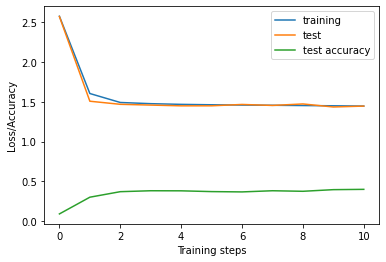

In [8]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)

plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()